In [11]:
import cv2
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import time

In [12]:
# import yolo
net = cv2.dnn.readNet('Yolo_config/yolov3.weights', 'Yolo_config/yolov3.cfg')

# get out_layers
layer_names = net.getLayerNames()
out_layers_indexes = net.getUnconnectedOutLayers()
out_layers = [layer_names[index[0]-1] for index in out_layers_indexes]

with open('Yolo_config/coco.names.txt') as f:
    classes = f.read().split('\n')

In [13]:
# apply yolo

def apply_yolo(img):
    
    height, width, channels = img.shape
    blob = cv2.dnn.blobFromImage(img, 1/255, (608,608), (0,0,0), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(out_layers)
    
    # create boxes
    class_indexes = []
    class_scores = []
    boxes = []
    
    for out in outs:
        for obj in out:
            scores = obj[5:] # 5 first is coordinates, next is probabilities (scores)
            # index of classes (coco.names.txt) that objects were find
            class_index = np.argmax(scores) # find the class as best probability
            class_score = scores[class_index]
            if class_score > 0:
                # coordinates of object on img
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)

                # left top corner of object on img
                x = center_x - obj_width // 2
                y = center_y - obj_height // 2

                box = [x, y, obj_width, obj_height]            
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))
            
    # remove duplicate boxes by Non Maximum Suppression
    chosen_boxes_indeces = cv2.dnn.NMSBoxes(boxes, class_scores, 0.0, 0.4)
    
    number_of_cars_in_parking = 0
    
    for box_index in chosen_boxes_indeces:
        box_index = box_index[0] # unpack index because chosen_boxes_indeces [[],[],...,[]]
        # draw rectangle and text only for boxes(remove duplicate)
        img, n = draw_object(img, class_indexes[box_index], class_scores[box_index], boxes[box_index])
        # count number of cars in parking
        number_of_cars_in_parking = number_of_cars_in_parking + n
    
    img = number_of_cars(img, number_of_cars_in_parking)
    img = draw_parking_area(img)
    
    return img

In [14]:
number_history = [] #[[10,time.time()], [12,time.time()], [8,time.time()]]
duration = 30 # seconds

def number_of_cars(img, n):
    now = time.time()
    number_history.append([n, now])
    
    # count max average n for last 30 seconds
    counts = [pair[0] for pair in number_history if pair[1] >= (now - 30)]
    mid = sum(counts) / len(counts)
    mid_max_counts = [n for n in counts if n >= mid]
    mid_max = sum(mid_max_counts) / len(mid_max_counts)
    
    img = cv2.putText(img, 'Number of cars in parking: ' + str(int(np.ceil(mid_max))) + '/ ' + str(total), 
                        (5, 100), cv2.FONT_HERSHEY_SIMPLEX, fontScale1, (0,255,0), 2, cv2.LINE_AA)
    img = cv2.putText(img, 'Free parking places: ' + str(total - int(np.ceil(mid_max))), 
                        (5, 150), cv2.FONT_HERSHEY_SIMPLEX, fontScale1, (0,255,255), 2, cv2.LINE_AA)
    
    return img

In [15]:
def draw_object(img, index, score, box):
    
    # is car in parking?
    if check_car_in_parking_area(box, index):
        color = (0, 255, 0)
        n = 1
    else:
        color = (0, 0, 255)
        n = 0
    
    # rectangle for car
    x, y, w, h = box
    start = (x, y)
    end = (x + w, y + h)
    thickness = 2
    img = cv2.rectangle(img, start, end, color, thickness)
    
    # text under car
    text = classes[index] # + f" {round(score, 2)}" Class name + probability
    start = (x , y - 10)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontsize = 1
    img = cv2.putText(img, text, start, font, fontsize, color, thickness, cv2.LINE_AA)
    
    return img, n

In [24]:
# Parking
source = 'http://68.188.109.50/cgi-bin/camera'
parking_area = [
    [0,730, 300,900],
    [300,770, 500,1000],
    [500,800, 750,1000],
    [750,820, 1580,1000]
]
fontScale1 = 2
total = 50

In [25]:
# Street
#source = 'http://72.231.8.170:82/jpgmulreq/1/image.jpg?key=1516975535684&lq=1&1604763482'
#source = 'http://168.194.220.9:8080/webcapture.jpg?command=snap&channel=1?1604764377'
#parking_area = [
#    [550,200, 730,710]
#]

#fontScale1 = 0.5
#total = 7

In [26]:
def draw_parking_area(img):
    for area in parking_area:
        # rectangle for parking
        x1, y1, x2, y2 = area
        start = (x1, y1)
        end = (x2, y2)
        color = (255,0,255)
        thickness = 2
        img = cv2.rectangle(img, start, end, color, thickness)
    return img

In [27]:
def check_car_in_parking_area(box, class_index):
    name = classes[class_index]
    if name not in ['car', 'truck', 'bus']:
        return False
    
    x, y, obj_width, obj_height = box
    car_x_center = x + obj_width // 2
    car_y_center = y + obj_height // 2
    
    for area in parking_area:
        x1, y1, x2, y2 = area
        if (x1 <= car_x_center <= x2) and (y1 <= car_y_center <= y2):
            return True
    
    return False

Stopped


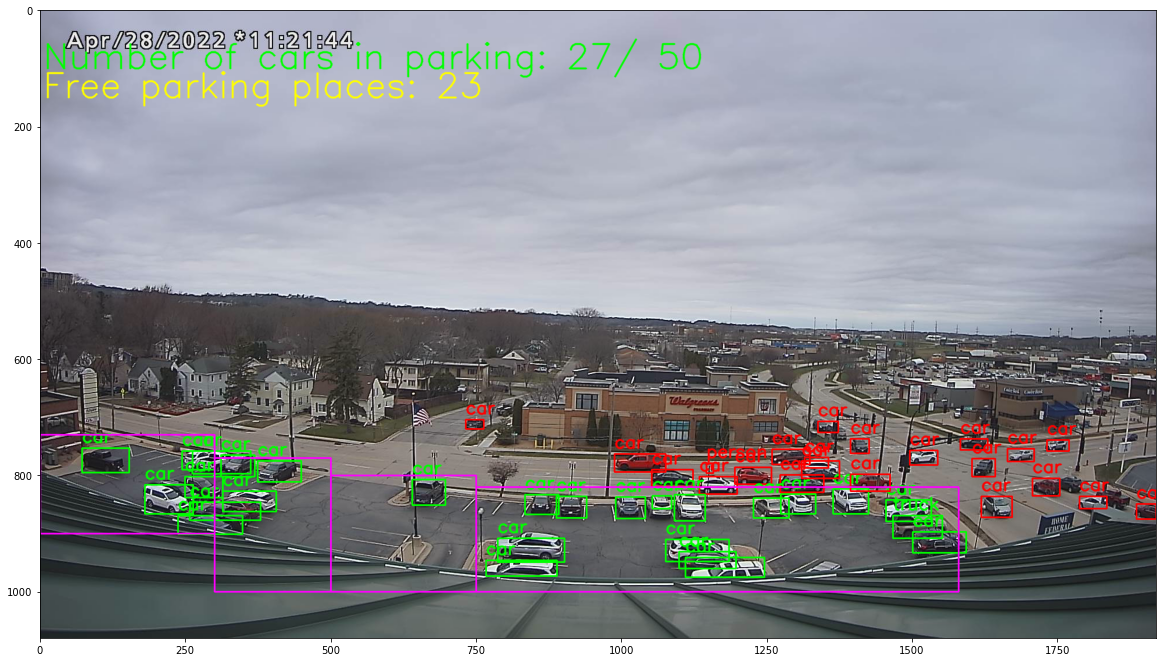

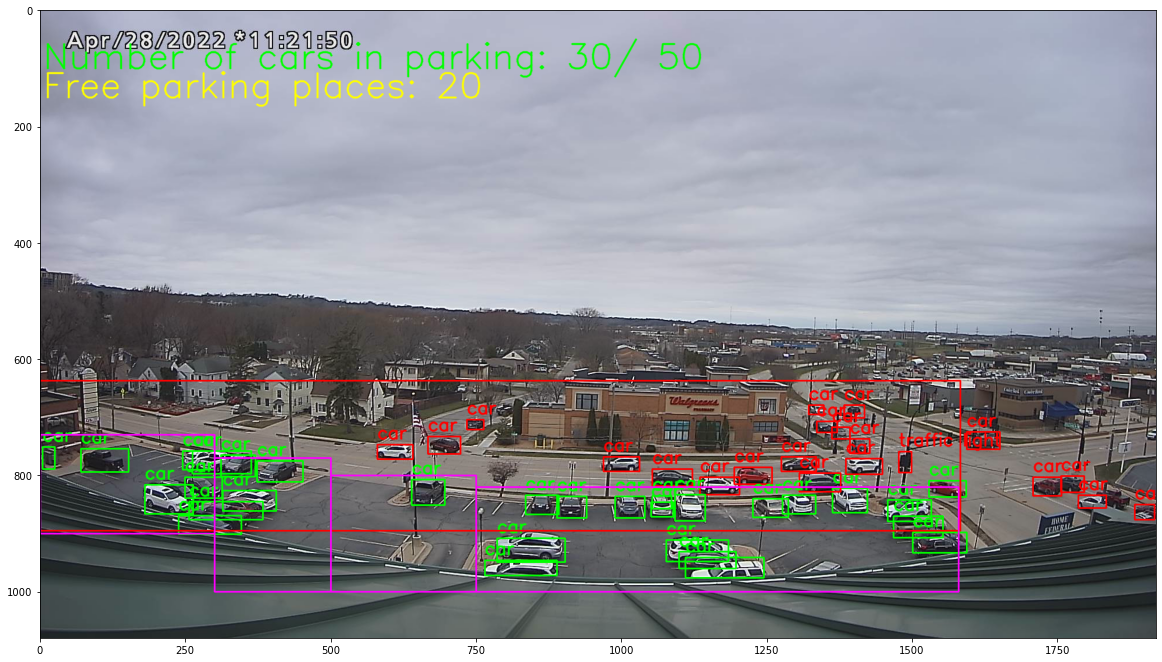

In [28]:
try:
    while True:
    
        cap = cv2.VideoCapture(source)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            #cv2.imwrite('CodeAndFilesDay2/camerashot.jpg', frame)
            frame = apply_yolo(frame)
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            #frame = cv2.resize(frame, (2560 // 2, 1440 // 2))

            plt.figure(figsize=(20,15))
            plt.imshow(frame)
            display.clear_output(wait=True)
            display.display(plt.gcf())

        cap.release()
except KeyboardInterrupt:
    display.clear_output()
    print('Stopped')